## FDTD for Schrodinger Eqn

This is a practice problem with finite difference time domain method.
Reference: [FDTD Algorithm Applied to the Schrödinger Equation](http://scipy-cookbook.readthedocs.io/items/SchrodingerFDTD.html)

In [1]:
import matplotlib.pyplot as plt

/Users/leima/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [2]:
import numpy as np

The porblem I am solving is the time dependent Schrodinger equation

\begin{equation}
i\frac{\partial}{\partial t} \psi = - \frac{\hbar}{2m} \frac{ \partial^2 }{ \partial t^2 } \psi + V \psi.
\end{equation}

The method is Finite Difference Time Domain (FDTD).

To define the problem, we consider 

1. a spatial range of $[0,1000]$,
2. with a box like potential between 8/10 and 9/10 of the spatial range,
3. the max of the potential is 1,
4. the incoming wave function is initialized to be a gaussian like wave packet, $ G(x) e^{ i(kx - \omega t) } $, where $G(x) = e^{ -( x- x_0 )^2/2\sigma^2 }$
5. wave number of the initial wave packet is $k = \pi/20$,
6. energy of the incoming particle is $E = \frac{\hbar^2}{2m} \left( k^2 + \frac{\sigma^2}{2} \right)  $


Now we set up the problem. We will seperate the real part and imaginary part of the wave function for numerical purpose.

In [3]:
BEG = 0
END = 1000
dx = 1
xarray = np.arange(BEG,END,dx)
Nx = len(xarray)
Nt = int( 15*len(xarray) )

## Physical Parameters

sigma = 40
hbar = 1
m = 1
k = np.pi/20
energy = hbar**2 * ( k**2 + 1/sigma**2/2 )/( 2* m)

In [4]:
energy

0.012493255501361697

In [5]:
def potential(x, potMax = None):
    """
    Define a potential for the scattering problem
    x should be an array
    """
    
    if potMax == None:
        potMax = 0.02
        
    length = len(x)
    potBegIdx = int(8*length/10)
    potEndIdx = int(9*length/10)
    
    pot = np.zeros(length)

    for i in np.arange(potBegIdx, potEndIdx):
        pot[i] = potMax
    
    return pot

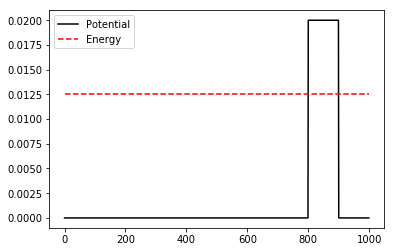

In [6]:
plt.plot( potential( xarray ),'-k', label='Potential')
plt.plot( np.array([energy for i in range(len(xarray))]), '--r', label='Energy' )
plt.legend()
plt.show()

In [7]:
def packet(x):
    """
    Initial wave packet
    """
    
    def GaussAmp(x,x0,sig = None):
        
        if sig == None:
            sig = sigma
        
        return np.exp(-( x-x0 )**2/(2*sig**2))

    
    length = len(x)
    pacBegIdx = int(1*length/10)
    pacCenIdx = int(1.5*length/10)
    pacEndIdx = int(2*length/10)
    
    psiR = np.zeros( (3,length) ) # first row is n-1, second row is n, last row is n+1
    psiI = np.zeros( (3,length) ) # same as above
    probability = np.zeros( (3,length) )
    
    amplitude = GaussAmp(x, x[pacCenIdx])
    
    psiR[0] = amplitude * np.cos(x*k)  # the n-1, aka past
    psiI[0] = amplitude * np.sin(x*k)
    
    psiR[1] = psiR[0]
    psiI[1] = psiI[0]
    
    probability = psiR**2 + psiI**2
    
    normal = (xarray[1] - xarray[0]) * np.sum(probability)
    
    return {'real':psiR/np.sqrt(normal), 'imag':psiI/np.sqrt(normal), 'prob':probability/normal, 'norm': normal }
    
    

In [8]:
packet(xarray)['norm']

141.79630076613952

In [9]:
(xarray[1] - xarray[0]) * np.sum( packet(xarray)['prob'] )

1.0

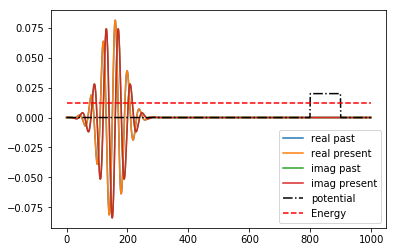

In [10]:
plt.plot( packet(xarray)['real'][0], label = 'real past' )
plt.plot( packet(xarray)['real'][1], label = 'real present')
plt.plot( packet(xarray)['imag'][0], label = 'imag past' )
plt.plot( packet(xarray)['imag'][1], label = 'imag present')
plt.plot( potential( xarray ), '-.k', label='potential')
plt.plot( np.array([energy for i in range(len(xarray))]), '--r', label='Energy' )
plt.legend()
plt.show()

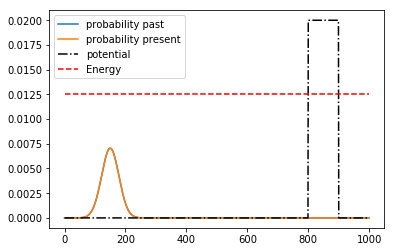

In [11]:
plt.plot( packet(xarray)['prob'][0], label = 'probability past' )
plt.plot( packet(xarray)['prob'][1], label = 'probability present' )
plt.plot( potential( xarray ), '-.k', label='potential')
plt.plot( np.array([energy for i in range(len(xarray))]), '--r', label='Energy' )
plt.legend()
plt.show()

## Iterations

To calculate the next time step we need to implement the update equations.

For convinience, we define two coefficients

\begin{align}
c_1 &= \frac{ \hbar \Delta t }{ 2m \Delta x^2 } \\
c_2 &= \frac{ \Delta t }{ \hbar }.
\end{align}

The notation I use here is similar to the one used in [Schrodinger_FDTD.pdf | scipy cookbook](http://scipy-cookbook.readthedocs.io/_downloads/Schrodinger_FDTD.pdf). $\psi^{n}_l = \psi(t_n, x_l)$. The update equations becomes

\begin{align}
psiR^{n+1}_l & = - c_1 \left( psiI^{n+1/2}_{l+1} - 2 psiI^{n+1/2}_l + psiI^{n+1/2}_{l-1} \right) + c_2 V_l psiI^{n+1/2}_l + psiR^n_l  \\
psiI^{n+1/2}_l &= c_1 \left( psiR^n_{l+1} - 2 psiR^n_{l} + psiR^n_{l-1} \right) - c_2 V_l psiR^n_{l} + psiI^{n-1/2}_l.
\end{align}

The time step size is not yet determined since we have not considered stability issues. 

\begin{equation}
\Delta t = \frac{\hbar}{(2\hbar^2/(m \Delta x^2)+V_{max})}
\end{equation}

In [12]:
dt = hbar/(2*hbar**2/( m*dx**2 )+ np.max( potential(xarray) ) )        #  Define the update time step

c1 = hbar*dt/(m*dx**2)
c2 = 2*dt/hbar   

The update is

-------------------------------------
Time Step 0
Probability Normalization Check 1.00007993021


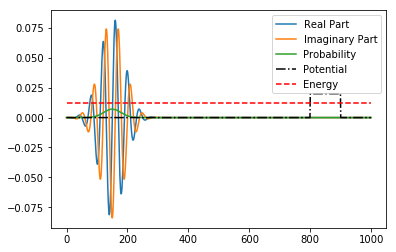

-------------------------------------
Time Step 1000
Probability Normalization Check 1.00003998031


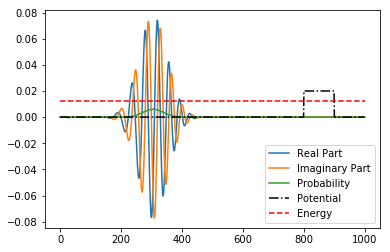

-------------------------------------
Time Step 2000
Probability Normalization Check 1.00003996292


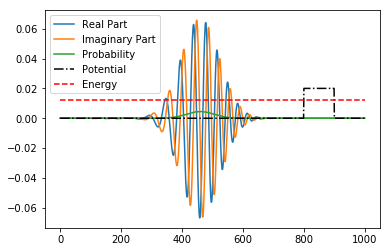

-------------------------------------
Time Step 3000
Probability Normalization Check 1.00002468832


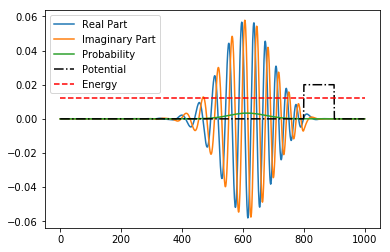

-------------------------------------
Time Step 4000
Probability Normalization Check 1.00357808272


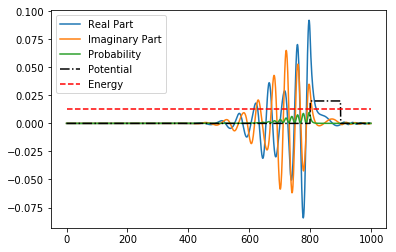

-------------------------------------
Time Step 5000
Probability Normalization Check 0.99915656271


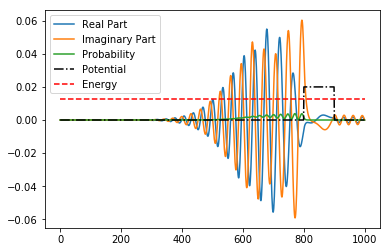

-------------------------------------
Time Step 6000
Probability Normalization Check 1.00009919329


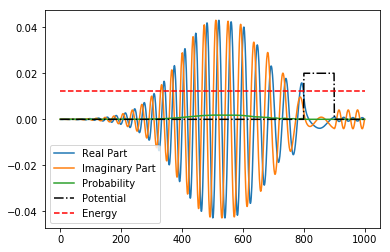

-------------------------------------
Time Step 7000
Probability Normalization Check 1.00003009373


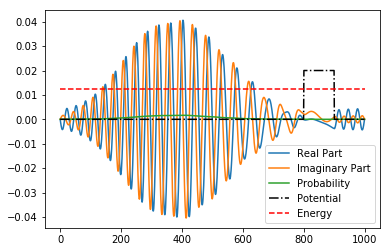

-------------------------------------
Time Step 8000
Probability Normalization Check 0.999585158215


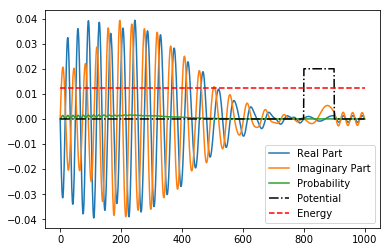

-------------------------------------
Time Step 9000
Probability Normalization Check 1.00130713754


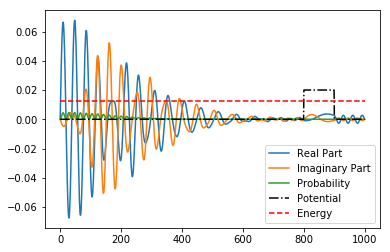

-------------------------------------
Time Step 10000
Probability Normalization Check 1.0019513313


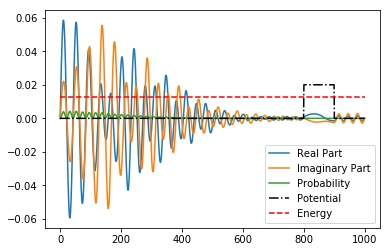

-------------------------------------
Time Step 11000
Probability Normalization Check 1.0003642989


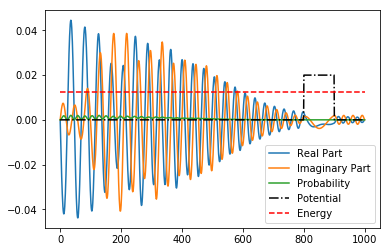

-------------------------------------
Time Step 12000
Probability Normalization Check 1.00013841288


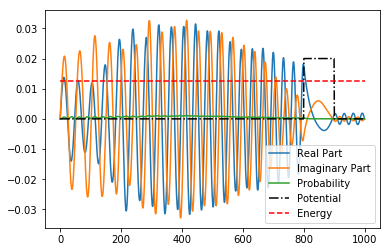

-------------------------------------
Time Step 13000
Probability Normalization Check 0.999436730456


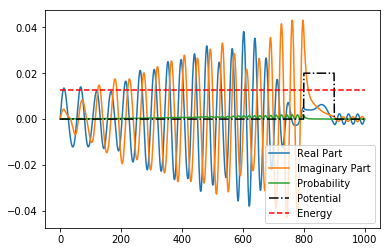

-------------------------------------
Time Step 14000
Probability Normalization Check 0.99974755079


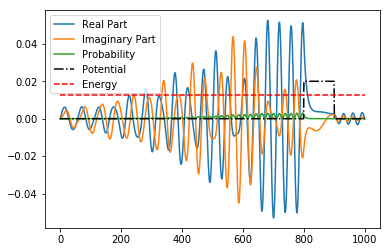

In [23]:
psiR = packet(xarray)['real']
psiI = packet(xarray)['imag']

for t in np.arange(0,Nt):
    
    # directly assign the indices to make the slicing faster
    # all psiR[n,l-1]: psiR[n, np.arange( 0, Nx-2 ) ]
    # all psiR[n,l]: psiR[n, np.arange(1,Nx-1)]
    # all psiR[n,l+1]: psiR[n, np.arange(2,Nx)]

    id0 = np.arange( 1, Nx-1 ) 
    id1 = np.arange( 2, Nx ) 
    id2 = np.arange( 0, Nx-2 ) 
    
    psiI[2,id0] = c1*( psiR[2,id1] - 2 * psiR[2,id0] + psiR[2,id2]  ) + psiI[1,id0]
    psiI[2] -= c2*potential(xarray) * psiR[2]
        
    psiR[2,id0] = -c1*( psiI[2,id1] - 2 * psiI[2,id0] + psiI[2,id2]   ) + psiR[1,id0]
    psiR[2] += c2 * potential(xarray) * psiI[2]
    

    psiR[0] = psiR[1]
    psiR[1] = psiR[2]
    psiI[0] = psiI[1]
    psiI[1] = psiI[2]
    
    
    if t % 1000 == 0:
        
        probCheck = psiR[1]**2 + psiI[1]**2
        normCheck = 2*(xarray[1] - xarray[0]) * np.sum(probCheck)
        print('-------------------------------------')
        print('Time Step',t )
        print('Probability Normalization Check', normCheck)
 
        
        plt.plot( psiR[1], label = 'Real Part' )
        plt.plot( psiI[1], label = 'Imaginary Part')
        plt.plot( probCheck, label='Probability' )
        plt.plot( potential( xarray ), '-.k', label='Potential')
        plt.plot( np.array([energy for i in range(len(xarray))]), '--r', label='Energy' )
#         plt.plot( np.array( [normCheck for i in range(len(xarray))] ), '-m', label='Normalization' )
        plt.legend()
        plt.show()
    